# IDM Engineering - March Madness Machine Learning - 2020

Welcome to the first 

## Library Imports

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [2]:
cwd = os.getcwd()

## What Year

The first decision you need to make, is how many years in the past you would like to build your model.

In [3]:
targetYear = 2015

In [4]:
# import tournament results and filter to only years > target year. 
tourney_cresults = pd.read_csv(cwd + '/data/MNCAATourneyCompactResults.csv')
tourney_cresults = tourney_cresults.loc[tourney_cresults['Season'] >= targetYear]
tourney_cresults.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
1916,2015,134,1214,74,1264,64,N,0
1917,2015,134,1279,94,1140,90,N,0
1918,2015,135,1173,56,1129,55,N,0
1919,2015,135,1352,81,1316,77,N,0
1920,2015,136,1112,93,1411,72,N,0


In [5]:
# create the training data set. Team 1 is winner, Team 2 is loser. 
training_set = pd.DataFrame()
training_set['Result'] = np.random.randint(0,2,len(tourney_cresults.index))
training_set['Season'] = tourney_cresults['Season'].values
training_set['Team1'] = training_set['Result'].values * tourney_cresults['WTeamID'].values + (1-training_set['Result'].values) * tourney_cresults['LTeamID'].values 
training_set['Team2'] = (1-training_set['Result'].values) * tourney_cresults['WTeamID'].values + training_set['Result'].values * tourney_cresults['LTeamID'].values
training_set.head()

,Result,Season,Team1,Team2
0,1,2015,1214,1264
1,1,2015,1279,1140
2,0,2015,1129,1173
3,1,2015,1352,1316
4,1,2015,1112,1411


In [6]:
# function to, given a row, calculate what the difference between the two seeds was. 
def delta_seed(row):
    cond = (seeds['Season'] == row['Season'])
    return seeds[cond & (seeds['TeamID'] == row['Team1'])]['Seed'].iloc[0] - seeds[cond & (seeds['TeamID'] == row['Team2'])]['Seed'].iloc[0]

In [7]:
#  Calculate Delta Seeds
seeds = pd.read_csv(cwd + '/data/MNCAATourneySeeds.csv')
seeds['Seed'] =  pd.to_numeric(seeds['Seed'].str[1:3], downcast='integer',errors='coerce')


training_set['deltaSeed'] = training_set.apply(delta_seed,axis=1)
training_set.head()

,Result,Season,Team1,Team2,deltaSeed
0,1,2015,1214,1264,0
1,1,2015,1279,1140,0
2,0,2015,1129,1173,0
3,1,2015,1352,1316,0
4,1,2015,1112,1411,-13


In [8]:
# # Calculate Delta Ordinals
# #mo = pd.read_csv('../input/masseyordinals/MasseyOrdinals.csv')
# mo = pd.read_csv(cwd + 'data/masseyordinals_thru_2019_day_128/MasseyOrdinals_thru_2019_day_128.csv')
# mo = mo[(mo['RankingDayNum'] == 128) & (mo['Season'] >= 2003)] # See Note on MO

# def delta_ord(row):
#     cond =  (mo['Season'] == row['Season'])
#     cond1 = (mo['TeamID'] == row['Team1']) & cond
#     cond2 = (mo['TeamID'] == row['Team2']) & cond
#     t1 = mo[cond1]['OrdinalRank'].mean()
#     t2 = mo[cond2]['OrdinalRank'].mean()
#     return  t1-t2

# training_set['deltaMO'] = training_set.apply(delta_ord,axis=1)

Define a function to 

In [9]:
#Function to look up 
def delta_winPct(row):
    cond1 = (record['Season'] == row['Season']) & (record['WTeamID'] == row['Team1'])
    cond2 = (record['Season'] == row['Season']) & (record['WTeamID'] == row['Team2'])
    return (record[cond1]['wins']/record[cond1]['games']).mean() - (record[cond2]['wins']/record[cond2]['games']).mean()

In [10]:
# Calculate win pct

season_dresults = pd.read_csv(cwd +'/data/MRegularSeasonDetailedResults.csv')
record = pd.DataFrame({'wins': season_dresults.groupby(['Season','WTeamID']).size()}).reset_index();
losses = pd.DataFrame({'losses': season_dresults.groupby(['Season','LTeamID']).size()}).reset_index();

record = record.merge(losses, how='outer', left_on=['Season','WTeamID'], right_on=['Season','LTeamID'])
record = record.fillna(0)
record['games'] = record['wins'] + record['losses']



training_set['deltaWinPct'] = training_set.apply(delta_winPct,axis=1)

In [11]:
record.head()

,Season,WTeamID,wins,LTeamID,losses,games
0,2003,1102.0,12.0,1102.0,16.0,28.0
1,2003,1103.0,13.0,1103.0,14.0,27.0
2,2003,1104.0,17.0,1104.0,11.0,28.0
3,2003,1105.0,7.0,1105.0,19.0,26.0
4,2003,1106.0,13.0,1106.0,15.0,28.0


In [12]:
training_set['deltaWinPct'] = training_set.apply(delta_winPct,axis=1)
training_set.head()

,Result,Season,Team1,Team2,deltaSeed,deltaWinPct
0,1,2015,1214,1264,0,-0.108902
1,1,2015,1279,1140,0,-0.093750
2,0,2015,1129,1173,0,-0.015640
3,1,2015,1352,1316,0,-0.069404
4,1,2015,1112,1411,-13,0.264706


In [13]:
# create dataframes of both winners and losers
dfW = season_dresults.groupby(['Season','WTeamID']).sum().reset_index()
dfL = season_dresults.groupby(['Season','LTeamID']).sum().reset_index()

In [14]:
def get_points_against(row):
    wcond = (dfW['Season'] == row['Season']) & (dfW['WTeamID'] == row['WTeamID']) 
    fld1 = 'LScore'
    lcond = (dfL['Season'] == row['Season']) & (dfL['LTeamID'] == row['WTeamID']) 
    fld2 = 'WScore'
    retVal = dfW[wcond][fld1].sum()
    if len(dfL[lcond][fld2]) > 0:
        retVal = retVal + dfL[lcond][fld2].sum() 
    return retVal

In [15]:
def get_points_for(row):
    wcond = (dfW['Season'] == row['Season']) & (dfW['WTeamID'] == row['WTeamID']) 
    fld1 = 'WScore'
    lcond = (dfL['Season'] == row['Season']) & (dfL['LTeamID'] == row['WTeamID']) 
    fld2 = 'LScore'
    retVal = dfW[wcond][fld1].sum()
    if len(dfL[lcond][fld2]) > 0:
        retVal = retVal + dfL[lcond][fld2].sum() 
    return retVal

In [16]:
# add points for and points against data
record['PointsFor'] = record.apply(get_points_for, axis=1)
record['PointsAgainst'] = record.apply(get_points_against, axis=1)

In [17]:
record.head()

,Season,WTeamID,wins,LTeamID,losses,games,PointsFor,PointsAgainst
0,2003,1102.0,12.0,1102.0,16.0,28.0,1603,1596
1,2003,1103.0,13.0,1103.0,14.0,27.0,2127,2110
2,2003,1104.0,17.0,1104.0,11.0,28.0,1940,1820
3,2003,1105.0,7.0,1105.0,19.0,26.0,1866,1993
4,2003,1106.0,13.0,1106.0,15.0,28.0,1781,1785


In [18]:
def get_remaining_stats(row, field):
    wcond = (dfW['Season'] == row['Season']) & (dfW['WTeamID'] == row['WTeamID']) 
    fld1 = 'W' + field
    lcond = (dfL['Season'] == row['Season']) & (dfL['LTeamID'] == row['WTeamID']) 
    fld2 = 'L'+ field
    retVal = dfW[wcond][fld1].sum()
    if len(dfL[lcond][fld2]) > 0:
        retVal = retVal + dfL[lcond][fld2].sum()
    return retVal
  

In [19]:
cols = ['FGM','FGA','FGM3','FGA3','FTM','FTA','OR','DR','Ast','TO','Stl','Blk','PF']

for col in cols:
    print("Processing",col)
    record[col] = record.apply(get_remaining_stats, args=(col,), axis=1)

#record['FGprct'] = record['FGM'] / record['FGA']  

Processing FGM
Processing FGA
Processing FGM3
Processing FGA3
Processing FTM
Processing FTA
Processing OR
Processing DR
Processing Ast
Processing TO
Processing Stl
Processing Blk
Processing PF


In [20]:
def delta_stat(row, field):
    cond1 = (record['Season'] == row['Season']) & (record['WTeamID'] == row['Team1'])
    cond2 = (record['Season'] == row['Season']) & (record['WTeamID'] == row['Team2'])
    return (record[cond1][field]/record[cond1]['games']).mean() - (record[cond2][field]/record[cond2]['games']).mean()

cols = ['PointsFor','PointsAgainst','FGM','FGA','FGM3','FGA3','FTM','FTA','OR','DR','Ast','TO','Stl','Blk','PF']

for col in cols:
    print("Processing",col)
    training_set['delta' + col] = training_set.apply(delta_stat,args=(col,),axis=1)

training_set.describe()

Processing PointsFor
Processing PointsAgainst
Processing FGM
Processing FGA
Processing FGM3
Processing FGA3
Processing FTM
Processing FTA
Processing OR
Processing DR
Processing Ast
Processing TO
Processing Stl
Processing Blk
Processing PF


,Result,Season,Team1,Team2,deltaSeed,deltaWinPct,deltaPointsFor,deltaPointsAgainst,deltaFGM,deltaFGA,...,deltaFGA3,deltaFTM,deltaFTA,deltaOR,deltaDR,deltaAst,deltaTO,deltaStl,deltaBlk,deltaPF
count,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,...,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000
mean,0.510448,2017.000000,1299.749254,1299.167164,-0.391045,-0.004203,-0.171914,-0.086097,-0.101112,-0.079283,...,0.110042,0.004327,0.066694,0.047230,-0.241263,-0.073266,-0.129860,0.028798,-0.000090,-0.165877
std,0.500639,1.416329,105.651174,101.515118,7.362669,0.153260,7.115781,6.639479,2.899043,4.368730,...,4.121321,2.461016,3.486938,2.602795,2.640361,2.784869,1.794208,1.639811,1.476867,2.578457
min,0.000000,2015.000000,1107.000000,1101.000000,-15.000000,-0.469697,-17.151515,-18.468750,-7.787879,-12.614082,...,-13.394831,-7.562500,-10.062500,-7.692235,-8.543672,-9.220143,-5.273950,-6.089015,-4.511029,-7.256303
25%,0.000000,2016.000000,1221.500000,1211.000000,-7.000000,-0.102607,-4.853632,-4.368956,-1.923295,-3.021780,...,-2.560662,-1.668811,-2.176331,-1.677557,-1.872549,-1.616728,-1.280227,-0.915560,-0.985924,-1.815406
50%,1.000000,2017.000000,1295.000000,1301.000000,0.000000,0.000000,-0.687500,-0.184492,-0.321970,-0.016129,...,0.161905,0.117647,0.347426,0.031250,-0.090909,-0.107563,-0.121212,0.005515,0.032977,-0.147059
75%,1.000000,2018.000000,1397.000000,1394.500000,5.000000,0.093880,4.605169,4.029412,1.714471,3.014113,...,2.933040,1.703125,2.481357,1.815643,1.504289,1.790797,1.145221,1.059743,1.015597,1.638787
max,1.000000,2019.000000,1462.000000,1463.000000,15.000000,0.515152,20.121324,19.411290,7.748162,10.972538,...,12.033266,6.113971,10.772059,7.459893,7.968806,8.363636,4.854839,4.378676,4.941288,6.314338


In [33]:
training_set.columns

Index(['Result', 'Season', 'Team1', 'Team2', 'deltaSeed', 'deltaWinPct',
       'deltaPointsFor', 'deltaPointsAgainst', 'deltaFGM', 'deltaFGA',
       'deltaFGM3', 'deltaFGA3', 'deltaFTM', 'deltaFTA', 'deltaOR', 'deltaDR',
       'deltaAst', 'deltaTO', 'deltaStl', 'deltaBlk', 'deltaPF'],
      dtype='object')

In [23]:
import seaborn as sns

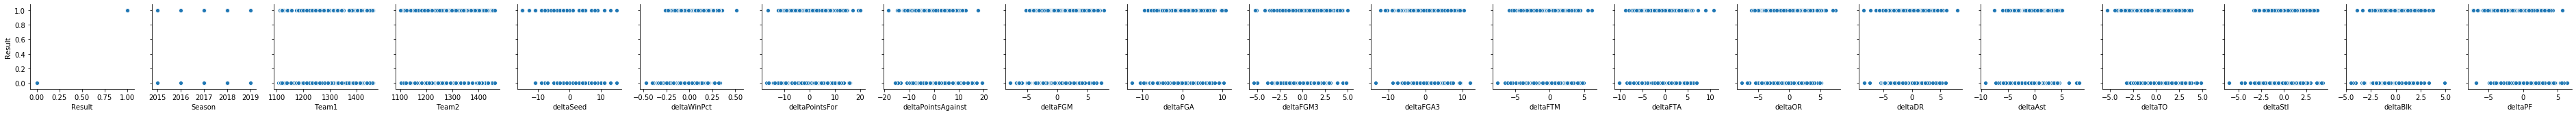

In [34]:
sns.pairplot(data = training_set, y_vars=["Result"], x_vars=training_set.columns)

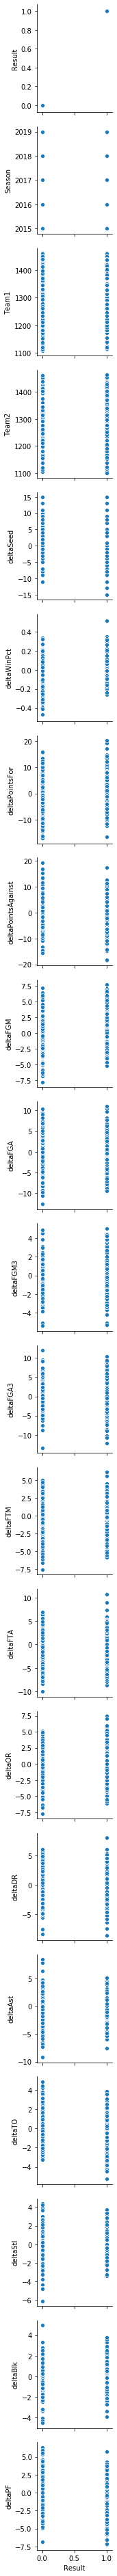

In [35]:
sns.pairplot(data = training_set, y_vars=training_set.columns, x_vars=["Result"])

In [37]:
correlation = training_set.corr()

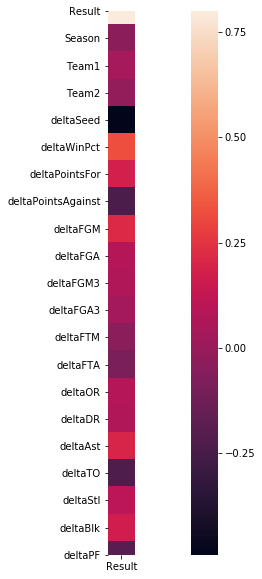

In [43]:
sns.heatmap(correlation[["Result"]], vmax=.8, square=True)

In [42]:
plt.rcParams['figure.figsize'] = (20.0, 10.0)

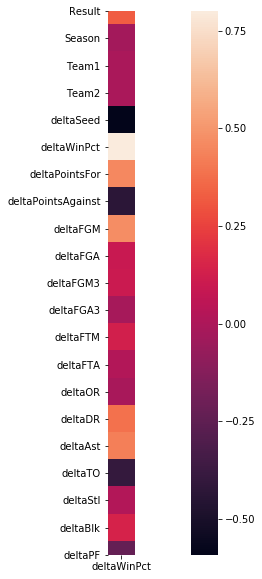

In [44]:
sns.heatmap(correlation[["deltaWinPct"]], vmax=.8, square=True)

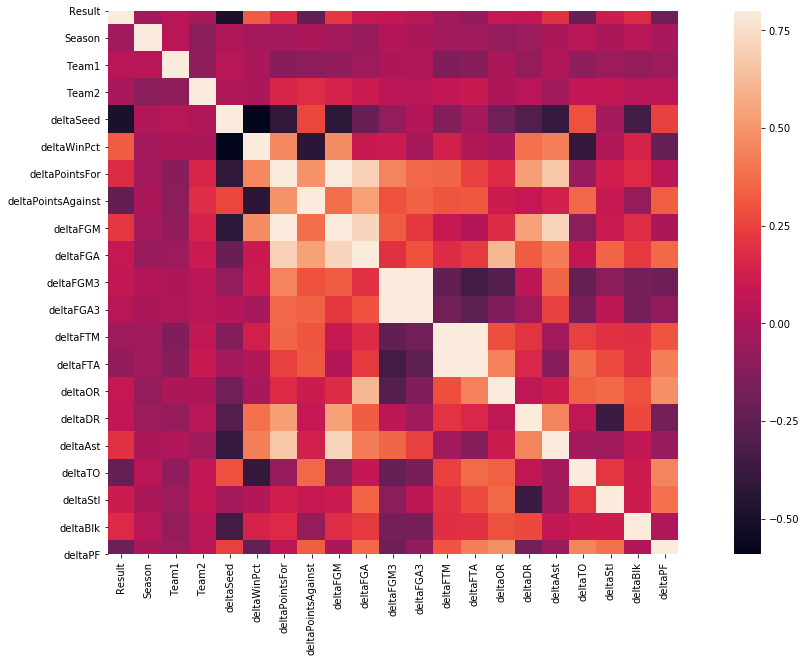

In [45]:
sns.heatmap(correlation, vmax=.8, square=True)

In [41]:
import matplotlib.pyplot as plt

In [21]:
training_set

,Result,Season,Team1,Team2,deltaSeed,deltaWinPct,deltaPointsFor,deltaPointsAgainst,deltaFGM,deltaFGA,...,deltaFGA3,deltaFTM,deltaFTA,deltaOR,deltaDR,deltaAst,deltaTO,deltaStl,deltaBlk,deltaPF
0,1,2015,1214,1264,0,-0.108902,-2.723485,0.500000,-0.088068,3.282197,...,-0.582386,-1.682765,-0.946970,1.836174,3.254735,-3.300189,-0.287879,-1.427083,1.309659,-1.360795
1,1,2015,1279,1140,0,-0.093750,-9.218750,-5.437500,-2.562500,-1.250000,...,-2.250000,-2.343750,-3.281250,0.468750,-0.687500,-3.437500,-0.218750,-0.531250,0.812500,-0.968750
2,0,2015,1129,1173,0,-0.015640,1.658847,0.026393,1.466276,4.263930,...,3.924731,-3.528837,-6.360704,1.091887,-0.088954,-2.108504,-1.259042,-1.001955,-0.222874,1.316716
3,1,2015,1352,1316,0,-0.069404,-4.935484,-0.788856,-0.503421,0.033236,...,-6.117302,-1.612903,-1.845552,0.908113,-1.741935,-1.176931,1.564027,2.448680,-0.996090,1.964809
4,1,2015,1112,1411,-13,0.264706,8.264706,-8.823529,3.352941,1.941176,...,-2.470588,1.794118,1.264706,-0.529412,3.235294,3.323529,-1.882353,1.029412,0.470588,0.558824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330,0,2019,1246,1120,-3,0.082888,-2.155080,-3.163993,-0.423351,-4.835116,...,-13.394831,4.073084,4.901070,-0.129234,4.877005,-0.563280,0.489305,-3.263815,0.295900,-2.079323
331,0,2019,1181,1277,-1,0.029412,4.676471,2.029412,2.735294,6.735294,...,2.441176,0.235294,2.088235,2.558824,-1.705882,-3.029412,0.264706,4.235294,1.352941,-1.058824
332,1,2019,1403,1277,1,-0.011029,-5.729779,-6.248162,-1.608456,-1.707721,...,-1.898897,-1.468750,-1.406250,-1.979779,-4.650735,-4.909926,-0.477941,2.139706,-0.564338,0.869485
333,0,2019,1120,1438,4,-0.170956,7.038603,13.525735,1.404412,6.847426,...,9.251838,1.286765,2.485294,2.860294,-3.808824,-0.088235,3.115809,3.669118,0.952206,3.726103


In [22]:
# Train a model on all of the data
import statsmodels.api as sm

# Field descriptions:
# deltaSeed: difference in team's seeds
# deltaMO: difference in team's Massey Ordinals on day 128
# deltaWinPct: difference in the team's winning percentage 
# deltaPointsFor: difference in the average points scored per game
# deltaPointsAgainst: difference in the average points scored agains the teams
# deltaFGM: difference in the field goals made per game
# deltaFGA: difference in the field goals attempted per game
# deltaFGM3: difference in 3 point fields goals made per game
# deltaFGA3: difference in the 3 points fields goals attempted per game
# deltaFTM: difference in free throws made per game
# deltaFTA: difference in free throws attempted per game
# deltaOR: difference in offence rebounds per game
# deltaDR: difference in defensive rebounds per game
# deltaAst: difference in assists per game
# deltaTO: difference in turnovers per game
# deltaStl: difference in steals per game
# deltaBlk: difference in blocks per game
# deltaPF: difference in personal fouls per game

# You would probabaly want to select a subset of these attributes
cols = ['deltaSeed', 'deltaWinPct','deltaPointsFor','deltaPointsAgainst','deltaFGM','deltaFGA','deltaFGM3','deltaFGA3','deltaFTM',
        'deltaFTA','deltaOR','deltaDR','deltaAst','deltaTO','deltaStl','deltaBlk','deltaPF']
X = training_set[cols]
y = training_set['Result']


## TODO.... create more models here
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())      

         Current function value: 0.519167
         Iterations: 35
                          Results: Logit
Model:               Logit            Pseudo R-squared: 0.251     
Dependent Variable:  Result           AIC:              379.8416  
Date:                2020-03-02 11:16 BIC:              440.8677  
No. Observations:    335              Log-Likelihood:   -173.92   
Df Model:            15               LL-Null:          -232.13   
Df Residuals:        319              LLR p-value:      9.3400e-18
Converged:           0.0000           Scale:            1.0000    
No. Iterations:      35.0000                                      
------------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
------------------------------------------------------------------
deltaSeed          -0.1445   0.0286 -5.0568 0.0000 -0.2005 -0.0885
deltaWinPct        -2.6277   1.9730 -1.3318 0.1829 -6.4948  1.2394
deltaPointsFor      0.

C:\Users\C176616\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\C176616\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:1286: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
C:\Users\C176616\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\C176616\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\C176616\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= 

In [46]:
# ordinary least squares
reg_model = sm.OLS(y,X)
result=reg_model.fit()
print(result.summary2())

                       Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.163   
Dependent Variable:     Result           AIC:                         681.4275
Date:                   2020-03-02 14:09 BIC:                         742.4536
No. Observations:       335              Log-Likelihood:              -324.71 
Df Model:               16               F-statistic:                 5.076   
Df Residuals:           319              Prob (F-statistic):          2.04e-09
R-squared (uncentered): 0.203            Scale:                       0.42727 
--------------------------------------------------------------------------------
                        Coef.    Std.Err.      t      P>|t|     [0.025    0.975]
--------------------------------------------------------------------------------
deltaSeed              -0.0323     0.0074   -4.3708   0.0000   -0.0469   -0.0178
deltaWinPct            -0.8065     0.5184   -1.5557   0.1208   -1.82

In [17]:
# Stats from previous competitions

winner=[0.52951,0.438933,0.481309,0.438575,0.531942]
top5=[0.54772,0.453872,0.519706,0.461073,0.549876]
topprctvalues=[5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]
topprctscores=[[0.55620,0.465207,0.536976,0.472893,0.576667,], # 5%
               [0.56035,0.469617,0.543597,0.479488,0.581399,], # 10%
               [0.56411,0.474137,0.550067,0.486432,0.586220,], # 15%
               [0.56958,0.478107,0.556954,0.491655,0.590554,], # 20%
               [0.57177,0.481519,0.563566,0.495595,0.594101,], # 25%
               [0.57495,0.486253,0.569619,0.500194,0.597493,], # 30%
               [0.57946,0.490536,0.577442,0.505821,0.601023,], # 35%
               [0.58676,0.496779,0.582541,0.511053,0.603920,], # 40%
               [0.59418,0.500862,0.585897,0.515844,0.608200,], # 45%
               [0.59921,0.508830,0.589459,0.522958,0.613297,], # 50%
               [0.60593,0.516735,0.594342,0.528533,0.621995,], # 55%
               [0.61288,0.523082,0.607036,0.534732,0.631227,], # 60%
               [0.61915,0.528358,0.627708,0.541466,0.645569,], # 65%
               [0.62780,0.539478,0.646980,0.556034,0.664821,], # 70%
               [0.65659,0.552809,0.682279,0.576019,0.688618,], # 75%
               [0.67932,0.574223,0.764058,0.605337,0.705595,], # 80%
               [0.73514,0.625012,0.865465,0.643514,0.776256,], # 85%
               [0.98764,0.692878,0.865465,0.693147,1.071796], # 90%
               [1.59656,0.882637,1.045207,0.897480,1.204277,], # 95%
               [19.18820,11.513103,9.092529,12.609623,18.092158,],] # 100%

In [19]:
# Run cross validation on model against tournaments in 2003-2018.  For the tournaments since 2014, the winning score
# from the Kaggle tournament is displayed

# TODO: Choose some columns to build the logistic regression models
cols = ['deltaWinPct', 'deltaPointsAgainst']

# TODO: Adjust winning probabilities by this percent for selected teams, based on your
biases = {
    '1163':1.2, # U Conn
    '1181':1.2, # Duke 
    '1437':1.2, # Villanova
    '1314':1.2, # UNC
}

errs = []
for year in range(2003,2019):
    print("Evaluation on tournament year",year)
    Xtrain = training_set[training_set['Season'] != year][cols]
    ytrain = training_set[training_set['Season'] != year]['Result']

    logit_model=sm.Logit(ytrain,Xtrain)
    result=logit_model.fit()

    Xtest = training_set[training_set['Season'] == year][cols]
    ytest = training_set[training_set['Season'] == year]['Result']
    
    pred = result.predict(Xtest)
    for bias in biases:
        pred.loc[(training_set['Season'] == year) & (training_set['Team1'] == int(bias))] = pred.loc[(training_set['Season'] == year) & (training_set['Team1'] == int(bias))] * biases[bias] 
        pred.loc[(training_set['Season'] == year) & (training_set['Team2'] == int(bias))] = pred.loc[(training_set['Season'] == year) & (training_set['Team2'] == int(bias))] / biases[bias] 
    
    pred.loc[(pred >= 0.9999)] = 0.9999
    pred.loc[(pred <= 0.0001)] = 0.0001

    pred.loc[training_set[training_set['Season'] == year]['Result'] == 0] = 1 - pred.loc[training_set[training_set['Season'] == year]['Result'] == 0] 
    err = -np.log(pred).mean()

    errs.append(err)

print("Mean log loss: ",np.mean(errs))



print("Log losses by season")
print("--------------------")
print("year","your score",sep="\t")
years1 = range(2003,2014)
for i in range(len(years1)):
    print(years1[i], "{0:.6f}".format(errs[i]),sep="\t")
    
print("Log losses by season")
print("--------------------")
print("year","your score","your result","winning score",sep="\t")    
years2 = range(2014,2019)
for i in range(len(years2)):
    result = None
    if errs[i+len(years1)] < winner[i]:
        result="Win competition"
    elif errs[i+len(years1)] < top5[i]:
        result="Top 5 score"
    else:
        for j in range(len(topprctvalues)):
            if errs[i+len(years1)] < topprctscores[j][i]:
                result = "Top " + str(topprctvalues[j]) + "%"
                break
        if result is None:
            result = "Worst score on Kaggle"

    print(years2[i], "{0:.6f}".format(errs[i+len(years1)]),result+"\t",winner[i],sep="\t")

Evaluation on tournament year 2003
Optimization terminated successfully.
         Current function value: 0.622756
         Iterations 5
Evaluation on tournament year 2004
Optimization terminated successfully.
         Current function value: 0.620744
         Iterations 5
Evaluation on tournament year 2005
Optimization terminated successfully.
         Current function value: 0.627135
         Iterations 5
Evaluation on tournament year 2006
Optimization terminated successfully.
         Current function value: 0.625783
         Iterations 5
Evaluation on tournament year 2007
Optimization terminated successfully.
         Current function value: 0.629864
         Iterations 5
Evaluation on tournament year 2008
Optimization terminated successfully.
         Current function value: 0.630568
         Iterations 5
Evaluation on tournament year 2009
Optimization terminated successfully.
         Current function value: 0.626288
         Iterations 5
Evaluation on tournament year 2010
Optimi

In [26]:
## Create a submission file
#sub = pd.read_csv('../input/SampleSubmissionStage1.csv')
sub = pd.read_csv(cwd + '/data/MSampleSubmissionStage1_2020.csv')

# Create predictor attributes (as above for the CV)
sub['Season'], sub['Team1'], sub['Team2'] = sub['ID'].str.split('_').str
sub[['Season', 'Team1', 'Team2']] = sub[['Season', 'Team1', 'Team2']].apply(pd.to_numeric)

sub['deltaSeed'] = sub.apply(delta_seed,axis=1)
# sub['deltaMO'] = sub.apply(delta_ord,axis=1)
sub['deltaWinPct'] = sub.apply(delta_winPct,axis=1)
cols = ['PointsFor','PointsAgainst','FGM','FGA','FGM3','FGA3','FTM','FTA','OR','DR','Ast','TO','Stl','Blk','PF']

for col in cols:
    print("Processing",col)
    sub['delta' + col] = sub.apply(delta_stat,args=(col,),axis=1)

# Build the final model
cols = ['deltaWinPct', 'deltaPointsAgainst']

# TODO: Adjust winning probabilities by this percent for selected teams, based on your
biases = {
    '1163':1.2, # U Conn
    '1181':1.2, # Duke 
    '1437':1.2, # Villanova
    '1314':1.2, # UNC
}

Xtrain = training_set[cols]
ytrain = training_set['Result']

logit_model=sm.Logit(ytrain,Xtrain)
result=logit_model.fit()

# Make your predictions
Xtest = sub[cols]
pred = result.predict(Xtest)

# Bias results based on team preferences
for bias in biases:
    pred.loc[sub['Team1'] == int(bias)] = pred.loc[sub['Team1'] == int(bias)] * biases[bias] 
    pred.loc[sub['Team2'] == int(bias)] = pred.loc[sub['Team2'] == int(bias)] / biases[bias] 
    
pred.loc[(pred >= 0.9999)] = 0.9999
pred.loc[(pred <= 0.0001)] = 0.0001


# Manually adjust some predictions
# U Conn vs Duke
pred.loc[(sub['Team1'] == 1163) & (sub['Team2'] == 1181)] = 0.8

# Create Submission file
sub['Pred'] = pred
sub[['ID', 'Pred']].to_csv('submission.csv', index=False)

Processing PointsFor
Processing PointsAgainst
Processing FGM
Processing FGA
Processing FGM3
Processing FGA3
Processing FTM
Processing FTA
Processing OR
Processing DR
Processing Ast
Processing TO
Processing Stl
Processing Blk
Processing PF
Optimization terminated successfully.
         Current function value: 0.625516
         Iterations 5


## Build bracket

## Import Dependencies

In [47]:
import os
import pkg_resources

from binarytree import Node
# import matplotlib.pyplot as plt # for notebook usage
# import numpy as np # for notebook usage
import pandas as pd
from PIL import Image, ImageDraw

import slot_coordinates


## Define Constants

In [48]:
__version__ = '0.2.0'

ID = 'id'
PRED = 'pred'
SEASON = 'season'
TEAM = 'teamname'

## Define Classes

In [49]:
class extNode(Node):
    def __init__(self, value, left=None, right=None, parent=None):
        Node.__init__(self, value, left=left, right=right)
        if parent is not None and isinstance(parent, extNode):
            self.__setattr__('parent', parent)
        else:
            self.__setattr__('parent', None)

    def __setattr__(self, name, value):
        # Magically set the parent to self when a child is created
        if (name in ['left', 'right']
                and value is not None
                and isinstance(value, extNode)):
            value.parent = self
        object.__setattr__(self, name, value)

## Define Functions

In [71]:
import os
#import pkg_resources

from binarytree import Node
# import matplotlib.pyplot as plt # for notebook usage
# import numpy as np # for notebook usage
import pandas as pd
from PIL import Image, ImageDraw

cwd = os.getcwd()

slot_coordinates = {
    2019: {1: (372, 32),# First four
         2: (372, 50),
         3: (30, 328),
         4: (30, 346),
         5: (695, 325),
         6: (695, 343),
         7: (370, 642),
         8: (370, 659),
         9:  (30, 532),# W1
         10: (30, 514),
         11: (30, 567),
         12: (30, 550),
         13: (30, 604),
         14: (30, 586),
         15: (30, 640),
         16: (30, 622),
         17: (30, 496),
         18: (30, 478),
         19: (30, 460),
         20: (30, 442),
         21: (30, 424),
         22: (30, 406),
         23: (30, 388),
         24: (30, 370),
         25: (30, 199),# X1
         26: (30, 182),
         27: (30, 236),
         28: (30, 218),
         29: (30, 272),
         30: (30, 254),
         31: (30, 308),
         32: (30, 290),
         33: (30, 164),
         34: (30, 146),
         35: (30, 128),
         36: (30, 110),
         37: (30, 92),
         38: (30, 74),
         39: (30, 55),
         40: (30, 38),
         41: (815, 532),# Y1
         42: (815, 514),
         43: (815, 567),
         44: (815, 550),
         45: (815, 604),
         46: (815, 586),
         47: (815, 640),
         48: (815, 622),
         49: (815, 496),
         50: (815, 478),
         51: (815, 460),
         52: (815, 442),
         53: (815, 424),
         54: (815, 406),
         55: (815, 388),
         56: (815, 370),
         57: (815, 199),# Z1
         58: (815, 182),
         59: (815, 236),
         60: (815, 218),
         61: (815, 272),
         62: (815, 254),
         63: (815, 308),
         64: (815, 290),
         65: (815, 164),
         66: (815, 146),
         67: (815, 128),
         68: (815, 110),
         69: (815, 92),
         70: (815, 74),
         71: (815, 55),
         72: (815, 38),
         73: (155, 523),# W2
         74: (155, 559),
         75: (155, 595),
         76: (155, 631),
         77: (155, 487),
         78: (155, 451),
         79: (155, 415),
         80: (155, 379),
         81: (155, 191),# X2
         82: (155, 227),
         83: (155, 263),
         84: (155, 299),
         85: (155, 155),
         86: (155, 119),
         87: (155, 83),
         88: (155, 47),
         89: (735, 523),# Y2
         90: (735, 559),
         91: (735, 595),
         92: (735, 631),
         93: (735, 487),
         94: (735, 451),
         95: (735, 415),
         96: (735, 379),
         97: (735, 191),# Z2
         98: (735, 227),
         99: (735, 263),
         100: (735, 299),
         101: (735, 155),
         102: (735, 119),
         103: (735, 83),
         104: (735, 47),
         105: (232, 541),# W3
         106: (232, 613),
         107: (232, 469),
         108: (232, 397),
         109: (232, 209),# X3
         110: (232, 281),
         111: (232, 137),
         112: (232, 65),
         113: (668, 541),# Y3
         114: (668, 613),
         115: (668, 469),
         116: (668, 397),
         117: (668, 209),# Z3
         118: (668, 281),
         119: (668, 137),
         120: (668, 65),
         121: (298, 576),# W4
         122: (298, 432),
         123: (298, 244),# X4
         124: (298, 100),
         125: (601, 576),# Y4
         126: (601, 432),
         127: (601, 244),# Z4
         128: (601, 100),
         129: (358, 504),# W5
         130: (358, 172),# X5
         131: (540, 504),# Y5
         132: (540, 172),# Z5
         133: (420, 457),# WX6
         134: (435, 219),# YZ6
         135: (435, 339)# CH
    }
}

class extNode(Node):
    def __init__(self, value, left=None, right=None, parent=None):
        Node.__init__(self, value, left=left, right=right)
        if parent is not None and isinstance(parent, extNode):
            self.__setattr__('parent', parent)
        else:
            self.__setattr__('parent', None)

    def __setattr__(self, name, value):
        # Magically set the parent to self when a child is created
        if (name in ['left', 'right']
                and value is not None
                and isinstance(value, extNode)):
            value.parent = self
        object.__setattr__(self, name, value)

def clean_col_names(df):
    return df.rename(columns={col: col.lower().replace('_', '') for col in df.columns})

def get_team_id(seedMap):
        return (seedMap, df[df['seed'] == seed_slot_map[seedMap]]['teamid'].values[0])

def get_team_ids_and_gid(slot1, slot2):
    team1 = get_team_id(slot1)
    team2 = get_team_id(slot2)
    if team2[1] < team1[1]:
        temp = team1
        team1 = team2
        team2 = temp
    gid = '{season}_{t1}_{t2}'.format(season=year, t1=team1[1], t2=team2[1])
    return team1, team2, gid

outputPath= cwd + '\\output.png'
teamsPath=cwd + '\\data\\Teams.csv'
seedsPath=cwd + '\\data\\2019TourneySeeds.csv'
slotsPath=cwd + '\\data\\MNCAATourneySlots.csv'
submissionPath=cwd + '\\submission.csv'
resultsPath=None
year=2019

submit = clean_col_names(pd.read_csv(submissionPath))

print(submit.head())


teams_df = clean_col_names(pd.read_csv(teamsPath))
seeds_df = clean_col_names(pd.read_csv(seedsPath))
slots_df = clean_col_names(pd.read_csv(slotsPath))

df = seeds_df.merge(teams_df, left_on='teamid', right_on='teamid')

df = df.drop(['firstd1season','lastd1season'], axis=1)

s = slots_df[slots_df['season'] == year]
seed_slot_map = {0: 'R6CH'}
bkt = extNode(0)


counter = 1
current_nodes = [bkt]
current_id = -1
current_index = 0

while current_nodes:
    next_nodes = []
    current_index = 0
    while current_index < len(current_nodes):
        node = current_nodes[current_index]
        if len(s[s['slot'] == seed_slot_map[node.value]].index) > 0:
            node.left = extNode(counter)
            node.right = extNode(counter + 1)
            seed_slot_map[counter] = s[s['slot'] == seed_slot_map[node.value]].values[0][2]
            seed_slot_map[counter + 1] = s[s['slot'] == seed_slot_map[node.value]].values[0][3]
            next_nodes.append(node.left)
            next_nodes.append(node.right)
            counter += 2
        current_index += 1
        current_id += 1
    current_nodes = next_nodes
    
# Solve bracket using predictions
# Also create a map with slot, seed, game_id, pred
    
results_df = pd.DataFrame({"id": [], "pred": []})
    
pred_map = {}
for level in list(reversed(bkt.levels)):
#     print(level)
    for ix, node in enumerate(level[0: len(level) // 2]):
#         print(node)
        team1, team2, gid = get_team_ids_and_gid(level[ix * 2].value, level[ix * 2 + 1].value)
        print(gid)
        pred = submit[submit['id'] == gid]['pred'].values[0]
        if gid in list(results_df.id):
            game_outcome = results_df[results_df[ID] == gid][PRED].values[0]
            team = team1 if game_outcome == 1 else team2
            if (game_outcome == 1 and pred > 0.5):
                # outcome agress with prediction, team1 wins
                pred_label = pred
            elif (game_outcome == 0 and pred > 0.5):
                # outcome different than prediction, team2 wins
                pred_label = 1 - pred
            elif (game_outcome == 0 and pred <= 0.5):
                # outcome agrees with prediction, team2 wins
                pred_label = 1 - pred
            elif (game_outcome == 1 and pred <= 0.5):
                # outcome different than prediction, team2 wins
                pred_label = pred
            else:
                raise ValueError("wat")

        elif pred >= 0.5:
            team = team1
            pred_label = pred
        else:
            team = team2
            pred_label = 1 - pred

        level[ix * 2].parent.value = team[0]
        pred_map[gid] = (team[0], seed_slot_map[team[0]], pred_label)
        
        
        
        
###################
slotdata = []
for ix, key in enumerate([b for a in bkt.levels for b in a]):
    xy = slot_coordinates[2019][max(slot_coordinates[2019].keys()) - ix]
    pred = ''
    gid = ''
    if key.parent is not None:
        team1, team2, gid = get_team_ids_and_gid(key.parent.left.value, key.parent.right.value)
    if gid != '' and pred_map[gid][1] == seed_slot_map[key.value]:
        pred = "{:.2f}%".format(pred_map[gid][2] * 100)
    st = '{seed} {team} {pred}'.format(
        seed=seed_slot_map[key.value],
        team=df[df['seed'] == seed_slot_map[key.value]]['teamname'].values[0],
        pred=pred
    )
    slotdata.append((xy, st))

# Create bracket image
# relevant:
# https://stackoverflow.com/questions/26649716/how-to-show-pil-image-in-ipython-notebook
#emptyBracketPath = pkg_resources.resource_filename(2017.jpg)
img = Image.open('2017.jpg')
draw = ImageDraw.Draw(img)
# font = ImageFont.truetype(<font-file>, <font-size>)
# draw.text((x, y),"Sample Text",(r,g,b))
for slot in slotdata:
    draw.text(slot[0], str(slot[1]), (0, 0, 0))

# dpi = 72
# margin = 0.05  # (5% of the width/height of the figure...)
# xpixels, ypixels = 940, 700

# Make a figure big enough to accomodate an axis of xpixels by ypixels
# as well as the ticklabels, etc...
# figsize = (1 + margin) * ypixels / dpi, (1 + margin) * xpixels / dpi
# fig = plt.figure(figsize=figsize, dpi=dpi)
# Make the axis the right size...
# ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])

# ax.imshow(np.asarray(img))
# plt.show() # for in notebook
img.save(outputPath)

               id      pred
0  2015_1107_1112  0.291137
1  2015_1107_1116  0.539806
2  2015_1107_1124  0.541594
3  2015_1107_1125  0.650091
4  2015_1107_1129  0.514887
2019_1295_1300
2019_1125_1396
2019_1192_1341
2019_1113_1385
2019_1181_1300
2019_1416_1433
2019_1387_1439
2019_1251_1280
2019_1133_1277
2019_1257_1278
2019_1261_1463
2019_1125_1268
2019_1211_1341
2019_1124_1393
2019_1199_1436
2019_1266_1293
2019_1276_1285
2019_1196_1305
2019_1297_1403
2019_1113_1138
2019_1233_1314
2019_1429_1449
2019_1242_1318
2019_1120_1308
2019_1101_1246
2019_1371_1459
2019_1209_1222
2019_1235_1326
2019_1205_1438
2019_1279_1328
2019_1243_1414
2019_1332_1458
2019_1159_1397
2019_1153_1234
2019_1330_1345
2019_1388_1437
2019_1181_1433
2019_1251_1439
2019_1277_1278
2019_1125_1261
2019_1211_1393
2019_1293_1436
2019_1276_1305
2019_1138_1403
2019_1314_1429
2019_1242_1308
2019_1246_1459
2019_1222_1235
2019_1279_1438
2019_1414_1458
2019_1153_1397
2019_1330_1437
2019_1181_1251
2019_1125_1277
2019_1211_1293
2019_11

In [207]:
%matplotlib qt
dpi = 300
margin = 0.05  # (5% of the width/height of the figure...)
xpixels, ypixels = 940, 700

# Make a figure big enough to accomodate an axis of xpixels by ypixels
# as well as the ticklabels, etc...
figsize = (1 + margin) * ypixels / dpi, (1 + margin) * xpixels / dpi
fig = plt.figure(figsize=figsize, dpi=dpi)
# Make the axis the right size...
ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])

ax.imshow(np.asarray(img))
plt.show() # for in notebook

In [194]:
import matplotlib.pyplot as plt

In [ ]:
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV

for name, model in models:
kfold = model_selection.KFold(n_splits=4, random_state=1)
cv_results = model_selection.cross_val_score(model, X_train, y_train, cv
results.append(cv_results)
names.append(name)
msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
print(msg)